In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops

In [2]:
num_classes =7
input_shape = (32, 32, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

x_train shape: (2036, 32, 32, 3) - y_train shape: (2036, 7)
x_val shape: (509, 32, 32, 3) - y_val shape: (509, 7)


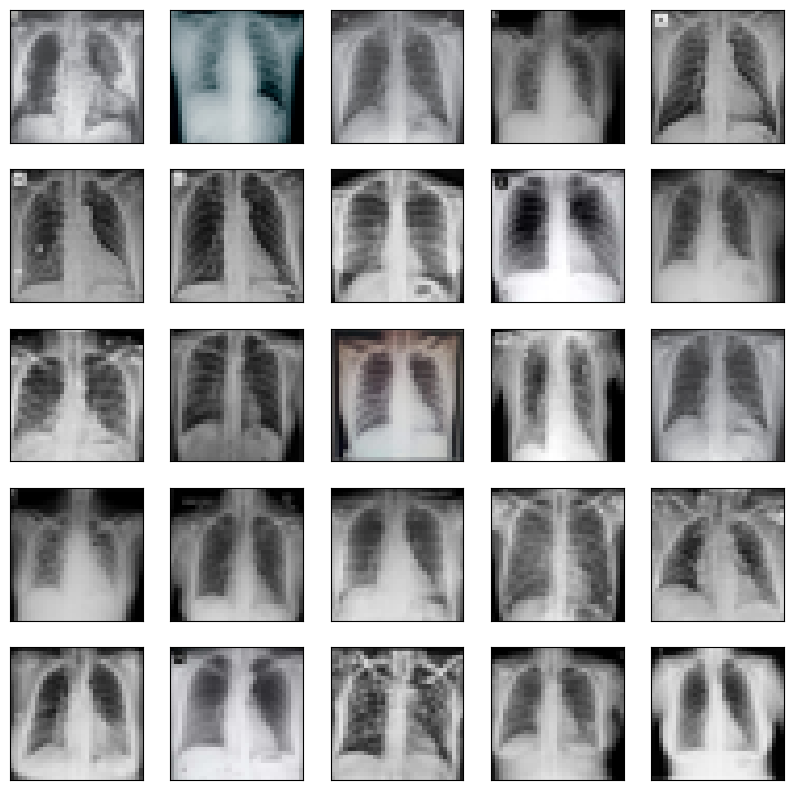

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from PIL import Image

# Assuming you have images in subdirectories of the specified directory
data_dir = r"D:\21PHD7008\sci3 paper dataset2\sci3paper datast3"
classes = os.listdir(data_dir)
num_classes = len(classes)

# Load images from the directory
x_train, y_train = [], []
for class_id, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        img = img.resize((32, 32))  # Resize the image to a fixed size
        img = np.array(img)
        if img.shape == (32, 32, 3):  # Ensure all images have the same shape
            x_train.append(img)
            y_train.append(class_id)

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Normalize the pixel values
x_train = x_train / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)

# Splitting data into train and validation sets
validation_split = 0.2
num_train_samples = int(len(x_train) * (1 - validation_split))
num_val_samples = len(x_train) - num_train_samples
x_train, x_val = np.split(x_train, [num_train_samples])
y_train, y_val = np.split(y_train, [num_train_samples])

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

# Visualization
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()


In [22]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

In [23]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


In [24]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [25]:
# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [27]:
# Load images from the directory for testing
x_test, y_test = [], []
for class_id, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        img = img.resize((32, 32))  # Resize the image to a fixed size
        img = np.array(img)
        if img.shape == (32, 32, 3):  # Ensure all images have the same shape
            x_test.append(img)
            y_test.append(class_id)

# Convert lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Normalize the pixel values
x_test = x_test / 255.0

# Convert labels to one-hot encoding
y_test = to_categorical(y_test, num_classes)

In [28]:
def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [29]:
input = layers.Input(shape=(256, 12))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [35]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(1, name="top-1-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8921 - loss: 0.7833 - top-1-accuracy: 0.8921 - val_accuracy: 0.9980 - val_loss: 0.5032 - val_top-1-accuracy: 0.9980
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4046 - loss: 2.5282 - top-1-accuracy: 0.4046 - val_accuracy: 0.8978 - val_loss: 0.8163 - val_top-1-accuracy: 0.8978
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4839 - loss: 1.7284 - top-1-accuracy: 0.4839 - val_accuracy: 0.8782 - val_loss: 0.8706 - val_top-1-accuracy: 0.8782
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7741 - loss: 0.8973 - top-1-accuracy: 0.7741 - val_accuracy: 0.8055 - val_loss: 0.9641 - val_top-1-accuracy: 0.8055
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9225 - loss: 0.6433 - top-1-accuracy: 0.9225 - val_accuracy: 0.9489 - val_loss: 0.6215 - val_top-1-accuracy: 0.9489
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8638 - loss: 0.7516 - top-1-accuracy

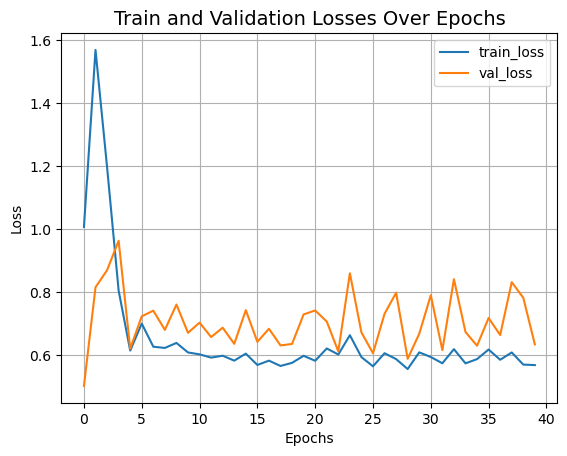

In [36]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

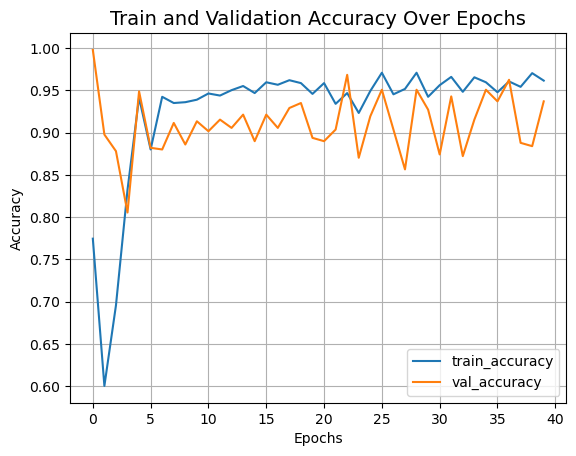

In [37]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [38]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.9771 - loss: 0.5617 - top-1-accuracy: 0.9771
Test loss: 0.56
Test accuracy: 97.49%
Test top 5 accuracy: 97.49%


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


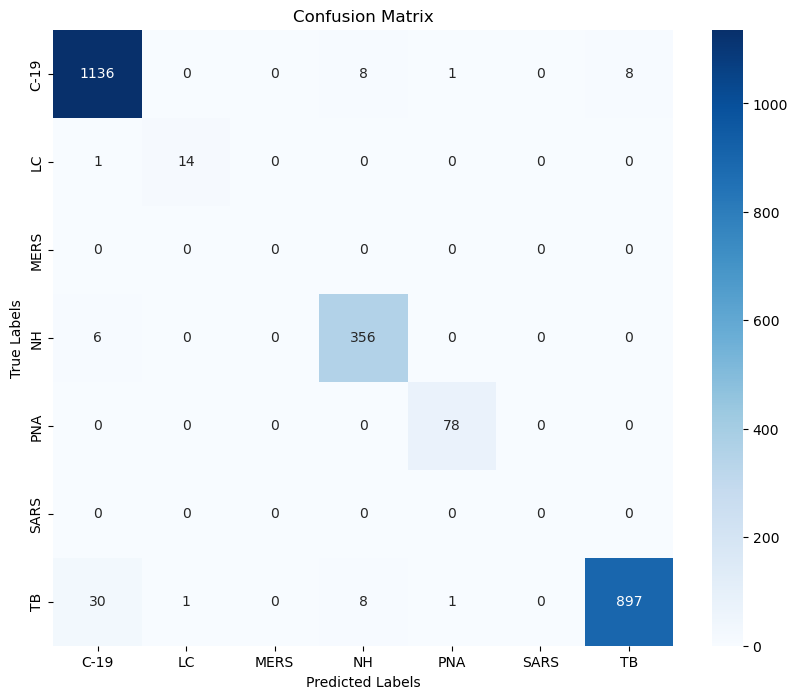

In [41]:
# Assuming you have already defined the 'patch_extract' function
import seaborn as sns

x_test_patches = patch_extract(x_test)

# Make predictions on test data patches
y_pred_patches = model.predict(x_test_patches)
y_pred_classes = np.argmax(y_pred_patches, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [43]:
NUM_CLASSES=7